# Tree building W 

In this notebook I sequentially build the best tree for patient W. The process goes as follows:

1. Build a tree class with the data as attribute
2. Find the 2 most covered mutations and build all potential trees
3. Run SVI on each tree independently
4. Select any tree with lowest ELBO in the last 20 iterations
5. Add the next most covered mutation and generate all potential trees
6. Repeat 3-5 until trees contain all mutations
7. Select one of the best trees and compute clonal assignment probabilities for single-cells

## Import packages 



<br>



In [2]:
# Import packages
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools
import os
import pickle
import collections


import dill

import time
from datetime import datetime
from timeit import default_timer as timer
from datetime import timedelta

import scipy
from scipy.stats import betabinom

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.optim import Adam, AdagradRMSProp, MultiStepLR
from torch.distributions import constraints
from pyro.ops.indexing import Vindex
pyro.set_rng_seed(100)

# import helper functions and tree class form source code files (present in the same directory)
from helper_functions import *

In [3]:
torch.set_default_tensor_type(torch.cuda.DoubleTensor)
patient = "AKLW"

## Load data

In [3]:
# load data from patient W
with open("data/"+patient+".json") as f:
    data = json.load(f)
       
# add type of mutations: 0 = CNV, 1 = nuclear, 2 = mitochondrial
data["type"] = np.array([1, 1, 1, 0])


In [4]:
data['colnames']

['KRAS', 'IDH2', 'NRAS', 'chr8']

# Build tree W

Here I heuristically build the clonal hierarchy of patient K

## Create tree class 


In [5]:
data_svi = {"M": torch.Tensor(data["M"]),
         "N": torch.Tensor(data["N"]),
         "mut_type": torch.Tensor([1,1,1,0]),
         "h_alpha": torch.Tensor([1000.0, 1000.0,1000.0, 2.]),
         "h_beta": torch.Tensor([1000.0,1000.0, 1000.0, 100.]),
         "af_alpha": torch.Tensor([[46, 22, 8, 12], [0,0,0,0]]),
         "af_beta": torch.Tensor([[100-46, 100-22, 100-8, 16], [1,1,1,1]]),
         "r_cnv": torch.Tensor([0,0,0,1.5]),
         "names": data["colnames"],
         "barcodes": data["cell_barcode"], 
         "umapx": data["umapx"], 
         "umapy": data["umapy"],
         "class_af": True, 
         "class_assign": torch.cuda.IntTensor(data["timepoint"]),
         "class_names": ["day0", "day15"],
         "cnv_celltype": False,                                         
         "celltype": [],
         "celltype_names": [],
         "cnv_ct_mean": [],
         "cnv_ct_sd": []}


In [6]:
t = tree(patient, data_svi)
t.sel_mutation(initial = True)

tensor([3, 0])

In [7]:
t.names

['KRAS', 'IDH2', 'NRAS', 'chr8']

## Initial tree with chr8 & KRAS

Choosing best tree among 4 potential candidates
Model fit to tree 0 in 1m 23s
Model fit to tree 1 in 1m 23s
Model fit to tree 2 in 1m 23s
Model fit to tree 3 in 1m 23s
Trees [0, 3] selected for mutations ['chr8', 'KRAS']
tensor([[0., 0.],
        [1., 0.],
        [1., 1.]])
tensor([[0., 0.],
        [1., 1.]])
Total run time 0h 5m 34s


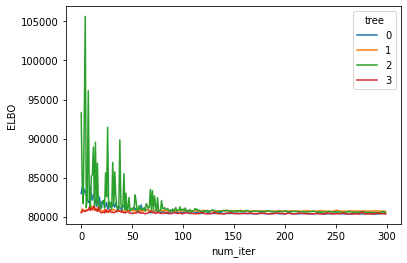

In [8]:
t.select_tree(num_iter = 500, init = 200)

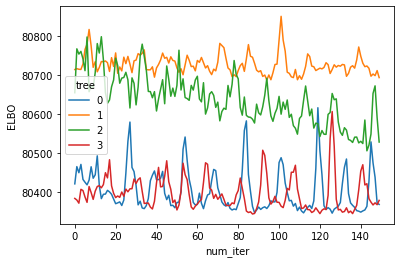

In [9]:
t.print_elbo(num_iter = 500, init = 350, include = [0,1,2,3])

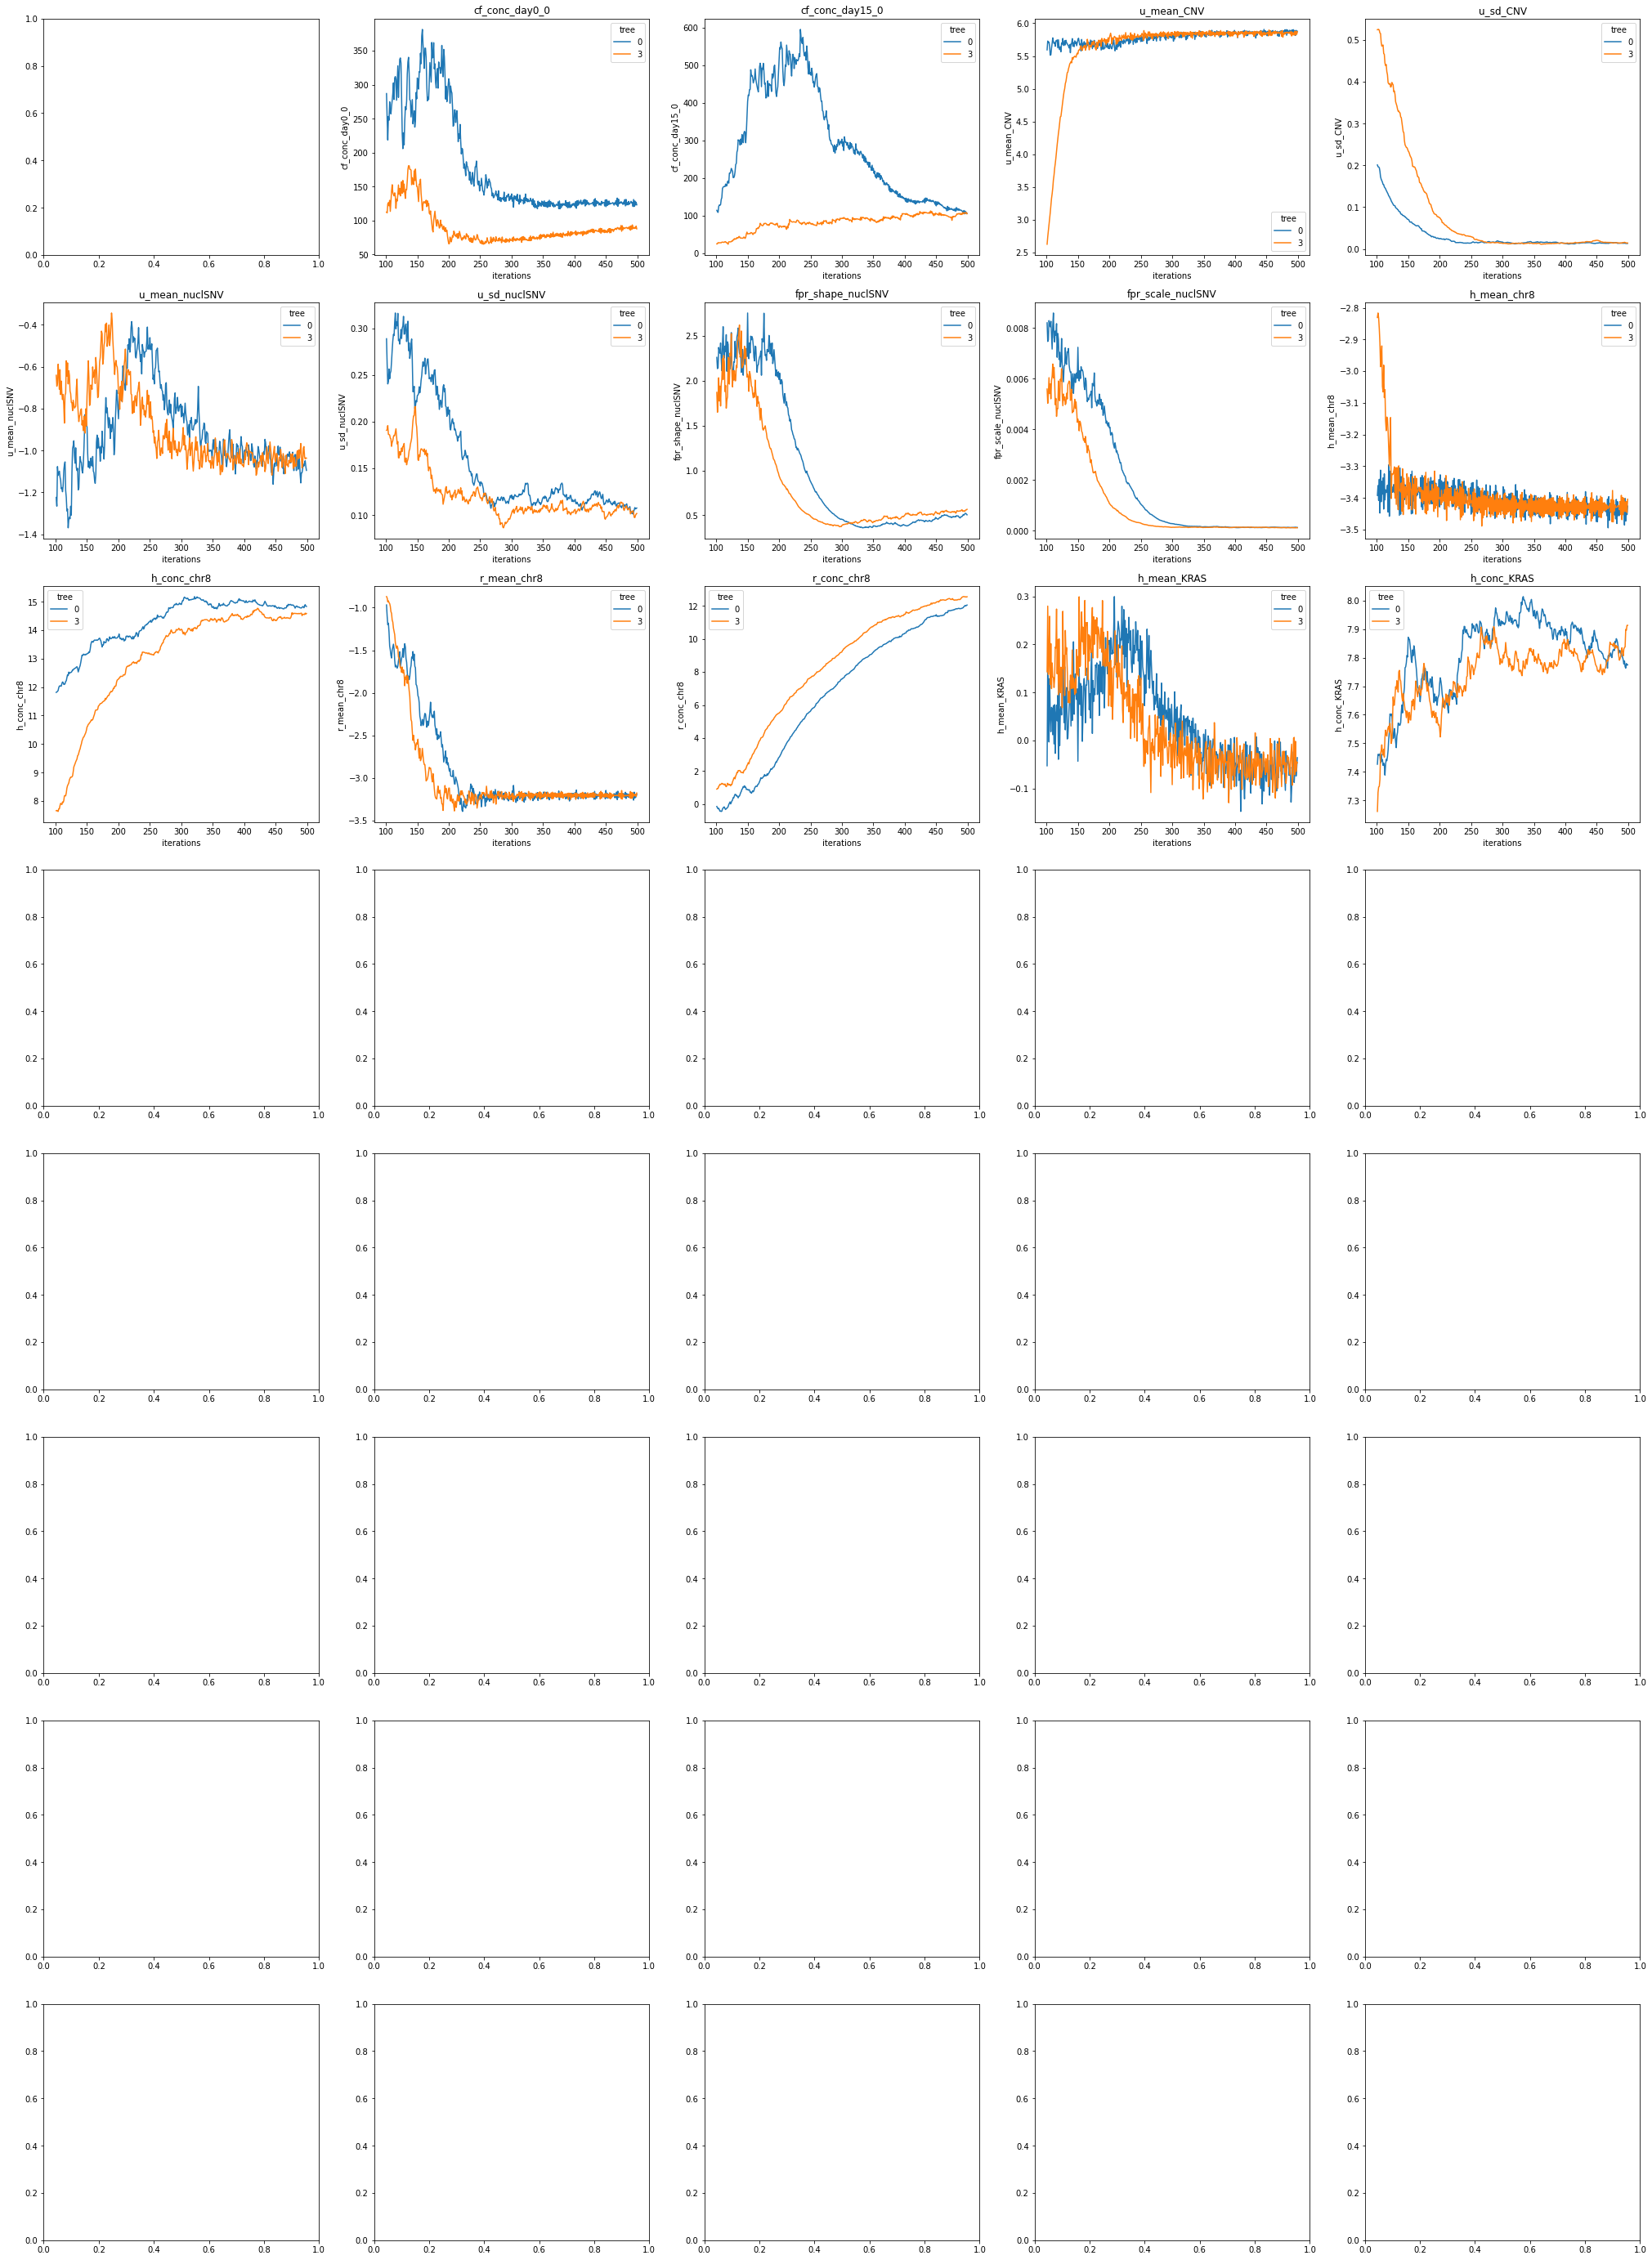

In [10]:
t.print_params(include = t.tree_indices, it = 100)

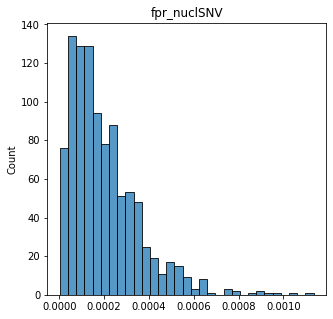

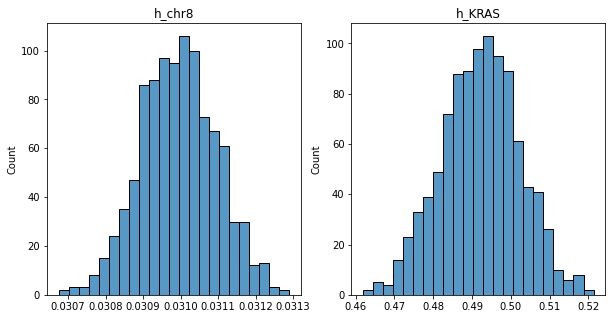

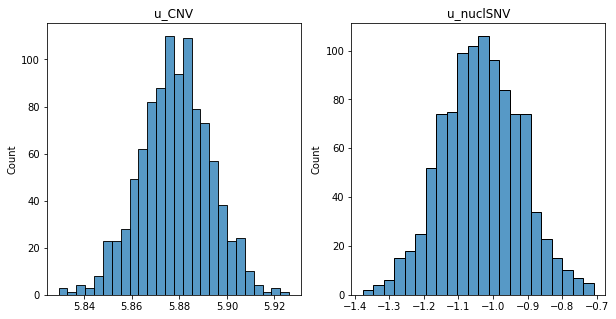

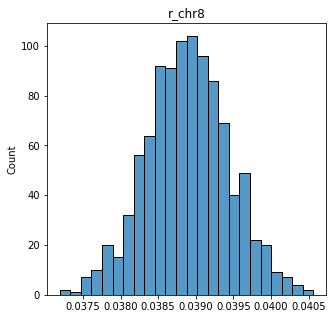

In [11]:
t.plot_posterior("all", 0, 1000)

## Add IDH2

IDH2 added to the tree
Choosing best tree among 11 potential candidates
Model fit to tree 0 in 1m 24s
Model fit to tree 1 in 1m 24s
Model fit to tree 2 in 1m 23s
Model fit to tree 3 in 1m 24s
Model fit to tree 4 in 1m 24s
Model fit to tree 5 in 1m 24s
Model fit to tree 6 in 1m 26s
Model fit to tree 7 in 1m 24s
Model fit to tree 8 in 1m 23s
Model fit to tree 9 in 1m 23s
Model fit to tree 10 in 1m 23s
Trees [1, 2, 4] selected for mutations ['chr8', 'KRAS', 'IDH2']
tensor([[0., 0., 0.],
        [0., 0., 1.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 0., 1.],
        [1., 1., 1.]])
Total run time 0h 15m 28s


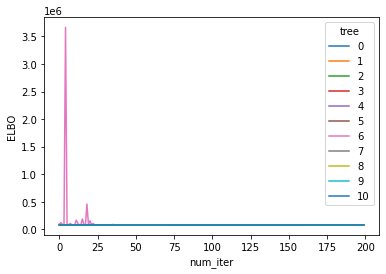

In [12]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 400, init = 200)

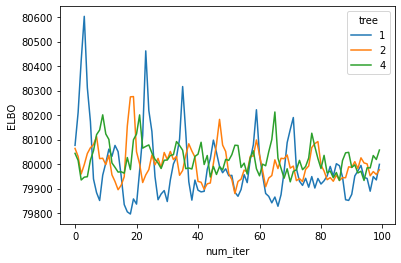

In [13]:
t.print_elbo(num_iter = 400, init = 300, include = [1,2,4])

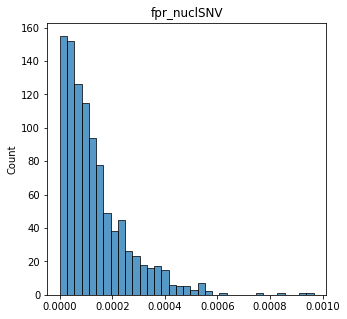

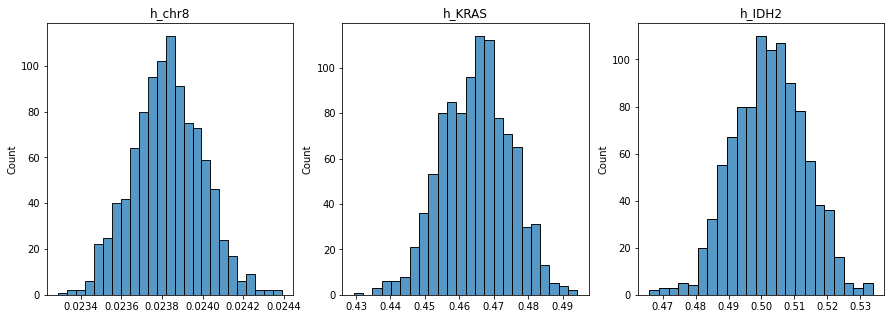

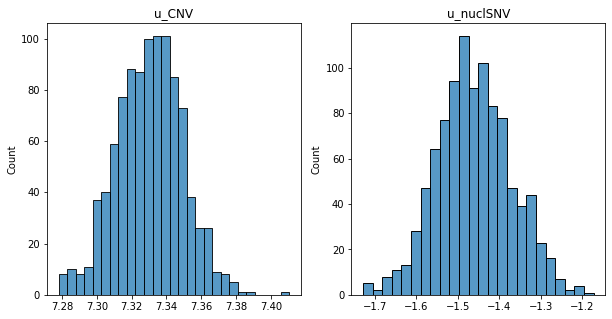

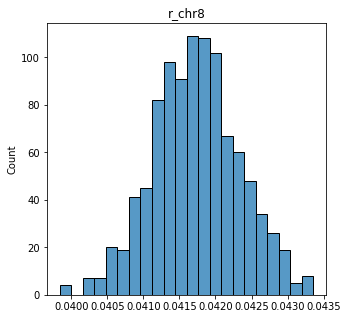

In [14]:
t.plot_posterior(variables = "all", tree = 1)

## Add NRAS

NRAS added to the tree
Choosing best tree among 27 potential candidates
Model fit to tree 0 in 1m 42s
Model fit to tree 1 in 1m 41s
Model fit to tree 2 in 1m 41s
Model fit to tree 3 in 1m 42s
Model fit to tree 4 in 1m 41s
Model fit to tree 5 in 1m 41s
Model fit to tree 6 in 1m 41s
Model fit to tree 7 in 1m 42s
Model fit to tree 8 in 1m 41s
Model fit to tree 9 in 1m 41s
Model fit to tree 10 in 1m 41s
Model fit to tree 11 in 1m 42s
Model fit to tree 12 in 1m 41s
Model fit to tree 13 in 1m 42s
Model fit to tree 14 in 1m 42s
Model fit to tree 15 in 1m 41s
Model fit to tree 16 in 1m 42s
Model fit to tree 17 in 1m 42s
Model fit to tree 18 in 1m 43s
Model fit to tree 19 in 1m 42s
Model fit to tree 20 in 1m 43s
Model fit to tree 21 in 1m 43s
Model fit to tree 22 in 1m 42s
Model fit to tree 23 in 1m 43s
Model fit to tree 24 in 1m 43s
Model fit to tree 25 in 1m 42s
Model fit to tree 26 in 1m 43s
Trees [4, 5, 6, 7, 8, 9, 15, 24, 25, 26] selected for mutations ['chr8', 'KRAS', 'IDH2', 'NRAS']
tens

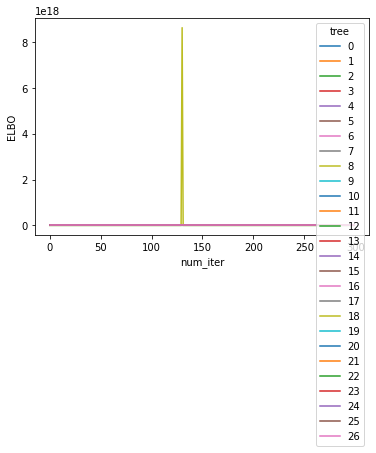

In [15]:
# add mutation and select the best tree(s)
t.add_mutation()
t.select_tree(num_iter = 400, init = 100)

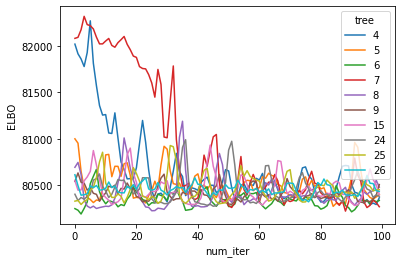

In [16]:
t.print_elbo(num_iter = 400, init = 300, include = t.tree_indices)

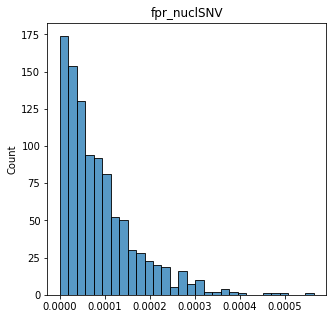

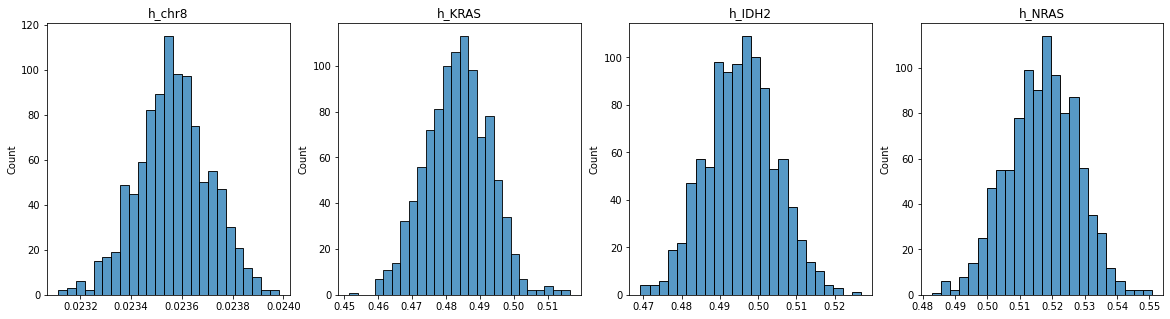

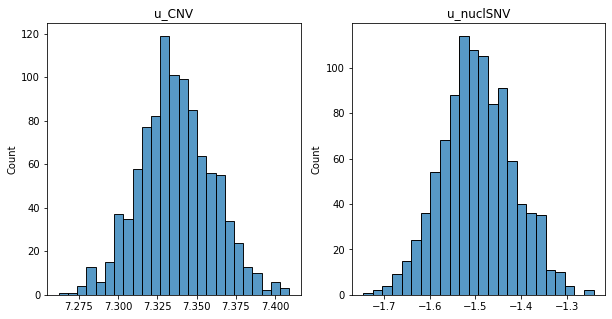

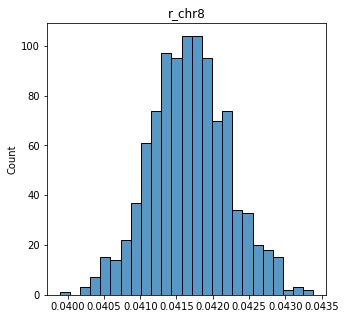

In [17]:
t.plot_posterior(variables = "all", tree = 6)

# Compute clonal assignments

In [18]:
for i in range(len(t.tree_indices)):
    t.clonal_assignment(tree = i)

Computing clonal assignment probabilities for tree 0
Clonal assignment probabilities computed in 1m and 42s
Computing clonal assignment probabilities for tree 1
Clonal assignment probabilities computed in 1m and 42s
Computing clonal assignment probabilities for tree 2
Clonal assignment probabilities computed in 1m and 42s
Computing clonal assignment probabilities for tree 3
Clonal assignment probabilities computed in 1m and 42s
Computing clonal assignment probabilities for tree 4
Clonal assignment probabilities computed in 1m and 41s
Computing clonal assignment probabilities for tree 5
Clonal assignment probabilities computed in 1m and 42s
Computing clonal assignment probabilities for tree 6
Clonal assignment probabilities computed in 1m and 40s
Computing clonal assignment probabilities for tree 7
Clonal assignment probabilities computed in 1m and 42s
Computing clonal assignment probabilities for tree 8
Clonal assignment probabilities computed in 1m and 41s
Computing clonal assignment 

In [23]:
# export object as pickle
t.export_pickle("svi_objects/AKLW.pickle")

Tree object saved as pickle!


In [ ]:
with open("svi_objects/tree_AKLW.pickle", "rb") as f:
    t = pickle.load(f)

# Posterior predictive

In [19]:
t.get_post_predictive(tree = 6, num_samples = t.M.shape[0])
with open("svi_objects/tree_AKLW.pickle", "wb") as f:
    pickle.dump(t,f,protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
with open("svi_objects/tree_AKLW.pickle", "rb") as f:
    t = pickle.load(f)

In [7]:
t.export_pickle("svi_objects/AKLW_post_pred.pickle")

Tree object saved as pickle!
